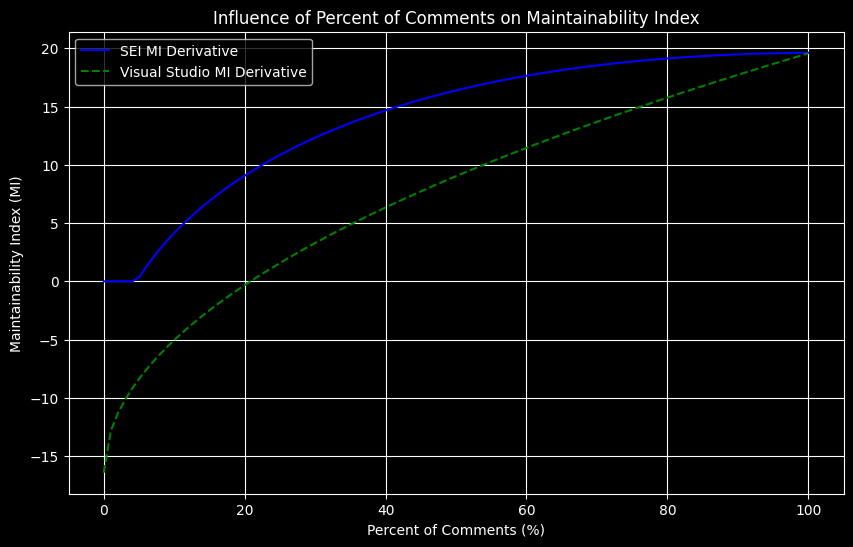

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the percentage of comments (as a range from 0% to 100%)
percent_comments = np.linspace(0, 100, 100)

# Define constants for the SEI and Visual Studio MI formulas
# These are placeholders; replace them with actual coefficients if available
V = 1000  # Cyclomatic complexity
G = 10   # Halstead effort
L = 10000  # Lines of code
C = percent_comments / 100  # Convert percentage to a fraction

# Compute the SEI MI derivative
MI_SEI = np.maximum(0, (171 - 5.2 * np.log(V) - 0.23 * G - 16.2 * np.log(L) + 50 * np.sin(np.sqrt(2.4 * C))) / 171 * 100)

# Compute the Visual Studio MI derivative (simplified version)
MI_VS = 171 - 5.2 * np.log(V) - 0.23 * G - 16.2 * np.log(L) + 36 * np.sqrt(C)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(percent_comments, MI_SEI, label="SEI MI Derivative", color="blue")
plt.plot(percent_comments, MI_VS, label="Visual Studio MI Derivative", color="green", linestyle="--")

# Add labels, title, and legend
plt.title("Influence of Percent of Comments on Maintainability Index")
plt.xlabel("Percent of Comments (%)")
plt.ylabel("Maintainability Index (MI)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [3]:
from pylint.reporters.base_reporter import BaseReporter
from pylint.reporters.ureports.nodes import Section

class ScoreOnlyReporter(BaseReporter):
    def __init__(self, output = None) -> None:
        super().__init__(output)
        self.name = "score-only"
    
    def handle_message(self, msg):
        pass

    def writeln(self, string = ""):
        pass

    def display_reports(self, layout):
        pass

    def _display(self, layout: Section):
        pass

    def on_close(self, stats, previous_stats):
        pass

In [4]:
from pylint.lint import Run
import os
import subprocess
from radon.metrics import mi_visit, h_visit
from radon.raw import analyze
import re

def get_maintainability_index(source_code, filepath='temp_code.py'):
    """
    Calculate the Maintainability Index of a given source code file.
    Args:
        source_code (str): The source code to analyze.
        filepath (str): The path to the file to save the source code temporarily.
    Returns:
        int: The Maintainability Index of the source code.
    """
    try:
        return int(mi_visit(source_code, True))
    except Exception as e:
        filename = filepath.split('/')[-1]
        with open(filename, "w") as f:
            f.write(source_code)
        result = subprocess.run(
            ['python2', '-m' 'radon', "mi", "-s", filename],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        maintainability_output = result.stdout
        match_mi = re.search(r"\((\d+)\)", maintainability_output)
        if match_mi:
            os.remove(filename)
            return int(match_mi.group(1))
        else:
            return 0
            raise Exception(f"File at {filepath} does not compile: {result.stderr}")
        
        
def get_pylint_score(source_code, filepath='temp_code.py'):
    filename = filepath.split("/")[-1]
    with open(filename, 'w') as f:
        f.write(source_code)
    try:
        print(source_code)
        pylint_results = Run([filename], ScoreOnlyReporter(), exit =False)
        os.remove(filename)
        return pylint_results.linter.stats.global_note
    except Exception as e:
        raise Exception(f"File {filepath} does not compile {e}")
    
class Python2LineMetics:
    def __init__(self, loc, lloc, sloc, comments, single_comments, multi, blank):
        self.loc = loc
        self.lloc = lloc
        self.sloc = sloc
        self.comments = comments
        self.single_comments = single_comments
        self.multi = multi
        self.blank = blank

    def __repr__(self):
        return f"LOC: {self.loc}, LLOC: {self.lloc}, SLOC: {self.sloc}, Comments: {self.comments}, Single Comments: {self.single_comments}, Multi: {self.multi}, Blank: {self.blank}"

def get_line_metrics(source_code, filepath='temp_code.py'):
    try:
        return analyze(source_code)
    except Exception as e:
        filename = filepath.split("/")[-1]
        with open(filename, 'w') as f:
            f.write(source_code)
        result = subprocess.run(
            ['python2', '-m' 'radon', "raw", filename],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        line_metrics_output = result.stdout
        loc = re.search(r"LOC:\s*(\d+)", line_metrics_output)
        lloc = re.search(r"LLOC:\s*(\d+)", line_metrics_output)
        sloc = re.search(r"SLOC:\s*(\d+)", line_metrics_output)
        comments = re.search(r"Comments:\s*(\d+)", line_metrics_output)
        single_comments = re.search(r"Single comments:\s*(\d+)", line_metrics_output)
        multi = re.search(r"Multi:\s*(\d+)", line_metrics_output)
        blank = re.search(r"Blank:\s*(\d+)", line_metrics_output)
        if loc and lloc and sloc and comments and single_comments and multi and blank:
            os.remove(filename)
            return Python2LineMetics(
                loc=int(loc.group(1)),
                lloc=int(lloc.group(1)),
                sloc=int(sloc.group(1)),
                comments=int(comments.group(1)),
                single_comments=int(single_comments.group(1)),
                multi=int(multi.group(1)),
                blank=int(blank.group(1))
            )
        else:
            raise Exception(f"File at {filepath} does not compile: {result.stderr}")
class Python2HelsteadTotal:
    def __init__(self, h1, h2, N1, N2):
        self.h1 = h1
        self.h2 = h2
        self.N1 = N1
        self.N2 = N2

class Python2HelsteadReport:
    def __init__(self, h1, h2, N1, N2):
        self.total = Python2HelsteadTotal(h1, h2, N1, N2)

    def __repr__(self):
        return f"""
        HelsteadReport(total: 
        h1={self.total.h1}, 
        h2={self.total.h2}, 
        N1={self.total.N1}, 
        N2={self.total.N2})"""

def get_halstead_metrics(source_code, filepath='temp_code.py'):
    """
    Calculate the Halstead metrics of a given source code file.
    Args:
        source_code (str): The source code to analyze.
        filepath (str): The path to the file to save the source code temporarily.
    Returns:
        dict: A dictionary containing the Halstead metrics.
    """
    try:
        return h_visit(source_code)
    except Exception as e:
        filename = filepath.split("/")[-1]
        with open(filename, 'w') as f:
            f.write(source_code)
        result = subprocess.run(
            ['python2', '-m' 'radon', "raw", filename],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        line_metrics_output = result.stdout
        theta_1 = re.search(r"h1:\s*(\d+)", line_metrics_output)
        theta_2 = re.search(r"h1:\s*(\d+)", line_metrics_output)
        N1 = re.search(r"N1:\s*(\d+)", line_metrics_output)
        N2 = re.search(r"N2:\s*(\d+)", line_metrics_output)
        
        if theta_1 and theta_2 and N1 and N2:
            os.remove(filename)
            return Python2HelsteadReport(
                h1=int(theta_1.group(1)),
                h2=int(theta_2.group(1)),
                N1=int(N1.group(1)),
                N2=int(N2.group(1))
            )
        else:
            return Python2HelsteadReport(
                h1=0,
                h2=0,
                N1=0,
                N2=0
            )
            raise Exception(f"File at {filepath} does not compile: {result.stderr}")


In [5]:
from pydriller import Repository
from datetime import datetime, timedelta
import pymongo

# Connect to MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")

# Define the repository parameters
repo_name = "Resume-Matcher"
repo_path = f"/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/tmp/{repo_name}"
end_date = datetime.now()
start_date = end_date - timedelta(days=6*365)

ocdb = myclient["OCEL"]

# Go through commits in the repository
# FIXME Instead of using snapshot, start with inital commit
python_files = set()
repository_code_metrics = dict()

# Snapshot of code quality for start of analysis
for commit in Repository(repo_path, since=start_date, only_modifications_with_file_types=[".py"], num_workers=1).traverse_commits():
    initial_commit = subprocess.run(['git', 'rev-parse', 'HEAD'], cwd=repo_path, stdout=subprocess.PIPE, text=True).stdout.strip()
    
    subprocess.run(['git', 'checkout', commit.hash], cwd=repo_path, check=True)
    result = subprocess.run(
        ["git", "ls-files", "*.py", "**/*.py"],
        cwd=repo_path,
        stdout=subprocess.PIPE,
        text=True,
        check=True
    )
    py_files = result.stdout.strip().split('\n')
    # Variant 1, check if simply passing the path is faster
    for file in py_files:
        try:
            with open(f"{repo_path}/{file}", 'r') as f:
                source_code = f.read()
        except Exception as e:
            print(f"Error reading file {file}: {e}")
        mi = get_maintainability_index(source_code)/100
        pl = get_pylint_score(source_code)/10
        repository_code_metrics[file] = [mi, pl]

    subprocess.run(['git', 'checkout', initial_commit], cwd=repo_path, check=True)
    break
    
for commit in Repository(repo_path, since=start_date, to=end_date, only_modifications_with_file_types=[".py"], num_workers=1).traverse_commits():
    file_mis = []
    file_pylints = []
    line_metrics = []
    helstead_metrics = []

    commit_mis = []
    commit_pylints = []

    # Go through modified files in the commit
    for modified_file in commit.modified_files:
        if modified_file.change_type.name == "ADD" and modified_file.new_path and modified_file.new_path.endswith(".py"):
            repository_code_metrics[modified_file.new_path] = [0, 0]
        elif modified_file.change_type.name == "DELETE" and modified_file.old_path and modified_file.old_path.endswith(".py"):
            repository_code_metrics.pop(modified_file.old_path, None)
            continue
        elif modified_file.change_type.name == "RENAME":
            if modified_file.old_path and modified_file.old_path.endswith(".py"):
                repository_code_metrics.pop(modified_file.old_path, None)
            if modified_file.new_path and modified_file.new_path.endswith(".py"):
                repository_code_metrics[modified_file.new_path] = [0, 0]
            if modified_file.source_code and modified_file.source_code_before:
                print(f"File LOC changed from {len(modified_file.source_code_before.split("\n"))} to {len(modified_file.source_code.split("\n"))}")
        elif modified_file.change_type.name == "MODIFY" and modified_file.new_path and modified_file.new_path.endswith(".py"):
            repository_code_metrics[modified_file.new_path] = [0, 0]
        else:
            continue
        
        if modified_file.new_path is None or modified_file.new_path.endswith(".py") == False:
            continue
        # Calculate code quality metrics
        # TODO Optimize by not analyzing files that are renamed
        if modified_file.source_code is None:
            source = ""
            print(f"File {modified_file.new_path} has no source code")
        else:
            source = modified_file.source_code
        mi = get_maintainability_index(source)/100
        pl = get_pylint_score(source)/10
        file_mis.append(mi)
        file_pylints.append(pl)

        repository_code_metrics[modified_file.new_path] = [mi, pl]

        line_metrics.append(get_line_metrics(source))
        helstead_metrics.append(get_halstead_metrics(source))

        # Create a dictionary for the commit
        type = "commit"
    for k,v in repository_code_metrics.items():
        commit_mis.append(v[0])
        commit_pylints.append(v[1])
    commit_mi = sum(commit_mis)/len(commit_mis) if commit_mis else 0
    commit_pylint = sum(commit_pylints)/len(commit_pylints) if commit_pylints else 0
    commit_dict = {
        "commit_date": commit.committer_date,
        "commit_author": commit.author.name,
        "commit_message": commit.msg,
        "commit_mi": commit_mi,
        "commit_pylint": commit_pylint,
        "commit_loc": sum([lm.loc for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_lloc": sum([lm.lloc for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_sloc": sum([lm.sloc for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_comments": sum([lm.comments for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_single_comments": sum([lm.single_comments for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_multi": sum([lm.multi for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_blank": sum([lm.blank for lm in line_metrics])/len(line_metrics) if line_metrics else 0,
        "commit_h1": sum([hm.total.h1 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
        "commit_h2": sum([hm.total.h2 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
        "commit_N1": sum([hm.total.N1 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
        "commit_N2": sum([hm.total.N2 for hm in helstead_metrics])/len(helstead_metrics) if helstead_metrics else 0,
    }
    ocdb[repo_name].replace_one({"_id": commit.hash}, {"type": type, "attributes": commit_dict}, upsert=True)

Previous HEAD position was fc46d27 Merge pull request #376 from JustinXre2020/bugfix_20250530
HEAD is now at 3071e17 Updating Progress


Previous HEAD position was 3071e17 Updating Progress
HEAD is now at fc46d27 Merge pull request #376 from JustinXre2020/bugfix_20250530


File Progress/Keywords.py has no source code

# Making a script for spacy's Rule based Matching

import spacy
import re

nlp = spacy.load('en_core_web_sm')

# Creating a Callback Pattern to return a string buffer is a pattern matches

def match_pattern(pattern, text):
	""" 
	This takes in spacy.matcher.Matcher patterns and 
	"""

	matches = matcher.add('',None,text)
	if len(matches) == 0:
		return False
	else:
		return True

import spacy
from spacy.matcher import Matcher, PhraseMatcher
import re

# Making a script for spacy's Rule based Matching

import spacy
import re
from spacy.matcher import Matcher, PhraseMatcher

nlp = spacy.load('en_core_web_sm')

# Creating a Callback Pattern to return a string buffer is a pattern matches

def is_pattern(pattern, text):
	""" 
	This takes in spacy.matcher.Matcher patterns and if a pattern is found 
    it returns true.
	"""

	matches = matcher.add('',None,text)
	if len(matches) == 0:
		return False
	else:
		return True 

import spacy
from spacy.m

In [6]:
import pymongo
# Connect to MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")

# Define the repository parameters
repo_path = f"/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/tmp/{repo_name}"


ocdb = myclient["OCEL"]
from matplotlib import pyplot as plt
import numpy as np
collection = ocdb[repo_name]
# Query the data
data = collection.find({"type": "commit"}, {"relationships.qualifier": "commit_pylint" }).sort("attributes.time", pymongo.ASCENDING)

# Extract commit_dates and maintainability indices
commit_dates = []
commit_pylints = []

def get_attribute_value(attributes, name):
    for attr in attributes:
        if attr.get("name") == name:
            return attr.get("value")

def get_related_objects(relationships, qualifier):
    related_object_ids = []
    for rel in relationships:
        if rel.get("qualifier") == qualifier:
            related_object_ids.append(rel.get("object")) 
    return related_object_ids if related_object_ids != [] else None

for record in data:
    if "attributes" in record and "relationships" in record:
        commit_dates.append(get_attribute_value(record["attributes"], "message"))
        commit_pylints.append(get_related_objects(record["relationships"], "commit_pylint"))
    else:
        print(f"Missing attributes in for record: {record}")
print(commit_pylints)
sorted_pylints = sorted(zip(commit_dates, commit_pylints), key=lambda x: x[0])
commit_dates, commit_pylints = zip(*sorted_pylints)

date_str = "2020-06-02T19:45:54.000+00:00"
date_obj_1 = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
date_obj_2 = datetime.fromisoformat(date_str.replace("020", "024"))
dt = np.array([date_obj_1, date_obj_2])
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(dt, [0, 1], label="Start", color="green", marker="o")
plt.plot(commit_dates, commit_pylints, label="Pylint Score", color="red", marker="x", linestyle="-")
plt.xlabel("Commit Date")
plt.ylabel("Code Quality Score")
plt.title(f"Code Quality Metrics Over Time for {repo_name}")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.ylim(0, 1.1)
plt.grid()
plt.legend()
plt.xticks(rotation=90)
plt.show()

Missing attributes in for record: {'_id': '3071e17d3625214bcaec418b7e1e005186d80597', 'relationships': {'qualifier': 'commit_pylint'}}
Missing attributes in for record: {'_id': '01d86e10a06c1d9f35238e6557bc85dda8d6fc1a', 'relationships': {'qualifier': 'commit_pylint'}}
Missing attributes in for record: {'_id': 'b5f93a1765d4b545846165699babe8b4f7010cc1', 'relationships': {'qualifier': 'commit_pylint'}}
Missing attributes in for record: {'_id': '807e81fe23ccfc32497c1bd43bf2fb5e429d06eb', 'relationships': {'qualifier': 'commit_pylint'}}
Missing attributes in for record: {'_id': '2c6791a73fcbb385c4596c8a545880fd54a525f7', 'relationships': {'qualifier': 'commit_pylint'}}
Missing attributes in for record: {'_id': '41f940bbe877608fb04a81a4e6469c4f3a1e203a', 'relationships': {'qualifier': 'commit_pylint'}}
Missing attributes in for record: {'_id': 'bdd3e9e46b3a91cf6e73b709691c5ff7340b96df', 'relationships': {'qualifier': 'commit_pylint'}}
Missing attributes in for record: {'_id': 'f14d939da334

ValueError: not enough values to unpack (expected 2, got 0)

In [7]:
from os import read
import pymongo
import ast
from build.utils import write_to_file
# Connect to MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
ocdb = myclient["OCEL"]
from build.database_handler import get_ocel_data

ocel_path = get_ocel_data()

In [15]:
import json

# Attempt to fix the JSON file if it uses single quotes
with open("Exports/OCEL-Data-Part1.json", "r") as f:
	content = f.read()

try:
	# Try to load as JSON directly
	data = json.loads(content)
except json.JSONDecodeError:
	# If it fails, try to eval as Python dict and dump as JSON
	import ast
	data = ast.literal_eval(content)
	with open("Exports/OCEL-Data-Part1.json", "w") as f:
		json.dump(data, f, indent=2)

from build.utils import validate_json
validate_json("Exports/OCEL-Data-Part1.json", "Data-Schemes/OCEL-Schema.json")


# filepath: test.ipynb
import pm4py

# 1. Load OCEL from JSON file
from pm4py.objects.ocel.importer.jsonocel.variants.ocel20_standard import apply
ocel = apply("Exports/OCEL-Data-Part1.json")

# 2. Discover the object-centric Petri net
from pm4py.algo.discovery.ocel.ocpn.algorithm import apply 
ocpn = apply(ocel)

# 3. Visualize the object-centric Petri net
from pm4py.visualization.ocel.ocpn import visualizer
gviz = visualizer.apply(ocpn)
visualizer.view(gviz)

KeyError: 'ocel:timestamp'

In [ ]:
import json
from datetime import datetime
from os import write

with open("Exports/OCEL-Data.json") as f:
    ocel = json.load(f)

# Define your split date(s)
split_date = datetime.fromisoformat("2023-01-01T00:00:00").replace(tzinfo=None)  # Ensure timezone-naive datetime

# Split events
events_part1 = [e for e in ocel["events"] if datetime.fromisoformat(e["time"]).replace(tzinfo=None) < split_date]
events_part2 = [e for e in ocel["events"] if datetime.fromisoformat(e["time"]).replace(tzinfo=None) >= split_date]

# (Optional) Get referenced object IDs for each part
def get_referenced_objects(events):
    obj_ids = set()
    for e in events:
        # Each relationship is a dict, e.g. {"object": "id", ...}
        for rel in e["relationships"]:
            obj_ids.add(rel["objectId"])  # or the correct key for the object ID
    return obj_ids

obj_ids_part1 = get_referenced_objects(events_part1)
obj_ids_part2 = get_referenced_objects(events_part2)

# (Optional) Filter objects for each part
objects_part1 = [o for o in ocel["objects"] if o["id"] in obj_ids_part1]
objects_part2 = [o for o in ocel["objects"] if o["id"] in obj_ids_part2]

# Build new OCEL logs
ocel_part1 = {**ocel, "events": events_part1, "objects": objects_part1}
ocel_part2 = {**ocel, "events": events_part2, "objects": objects_part2}

write_to_file("Exports/OCEL-Data-Part1.json", json.dumps(ocel_part1, indent=2))
write_to_file("Exports/OCEL-Data-Part2.json", json.dumps(ocel_part2, indent=2))


In [17]:
from pm4py import ocel_flattening as flatten

# ocel: your loaded OCEL log
user_log = flatten(ocel, "user")
write_to_file("Exports/OCEL-User-Log.json", json.dumps(user_log, indent=2))

AttributeError: 'dict' object has no attribute 'event_activity'

In [ ]:
f = get_pylint_score("""
print("Hello Pylint")
def hello_pylint():
    # A simple function to demonstrate Pylint functionality.
    
    print("Hello, Pylint!")
    return "Hello, Pylint!"

hello_pylint().replace("Pylint", "Code Quality")  # Example of a string operation
""")
print(f"PL Score: {f}")


print("Hello Pylint")
def hello_pylint():
    # A simple function to demonstrate Pylint functionality.
    
    print("Hello, Pylint!")
    return "Hello, Pylint!"

hello_pylint().replace("Pylint", "Code Quality")  # Example of a string operation

PL Score: 4.0


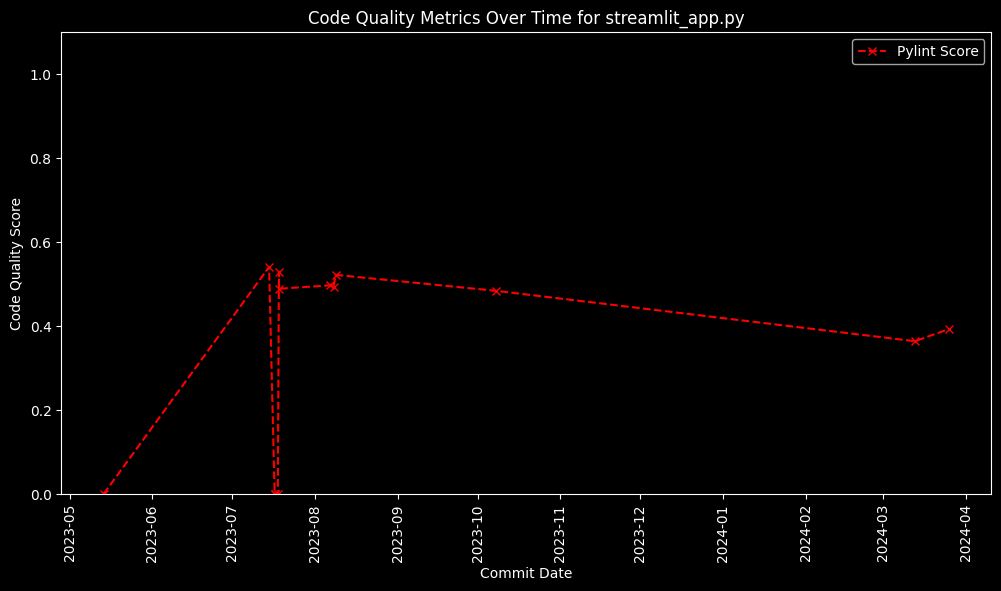

In [10]:
import pymongo
import matplotlib.pyplot as plt
import datetime

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
ocdb = myclient["OCEL"]

def get_object(id: str):
    """
    Get an object from the database by its ID.
    Args:
        id (str): The ID of the object to retrieve.
    Returns:
        dict: The object data if found, otherwise None.
    """
    return ocdb["ocel:objects"].find({"_id": id})[0]

def plot_file_code_quality(file_id):
    """
    Plot the code quality metrics for a specific file in the repository
    Args:
        repo_name (str): The name of the repository of the file file belongs to
        file_id (str): The ID of the file to plot the code quality metrics for
    """
    file = get_object(file_id)
    mis = {}
    pylint_scores = {}
    for attribute in file["attributes"]:
        if attribute["name"] == "pylint_score":
            pylint_scores[datetime.datetime.fromisoformat(attribute["time"]).replace(tzinfo=None)] = float(attribute["value"])
        if attribute["name"] == "loc":
            mis[datetime.datetime.fromisoformat(attribute["time"]).replace(tzinfo=None)] = int(attribute["value"])
    commit_dates = sorted(mis.keys())
    maintainability_indices = [mis[date] for date in commit_dates]
    plt.figure(figsize=(12, 6))
    # plt.plot(commit_dates, maintainability_indices, label="Maintainability Index", color="blue", marker="o", linestyle="-")
    plt.plot(commit_dates, [pylint_scores.get(date, 0) for date in commit_dates], label="Pylint Score", color="red", marker="x", linestyle="--")
    plt.xlabel("Commit Date")
    plt.ylabel("Code Quality Score")
    plt.title(f"Code Quality Metrics Over Time for {file['_id']}")
    plt.xticks(rotation=90)
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.ylim(0, 1.1)
    plt.legend()
    plt.savefig(f"Exports/{file['_id']}_code_quality.png")

plot_file_code_quality("streamlit_app.py")

In [11]:
from re import search
from attr import attrib


def get_attribute_value_at_time(file_id, attribute_name, searched_time):
    """
    Get the value of an attribute at a specific time.
    Args:
        file_id (str): The ID of the file to get the attribute value for.
        attribute_name (str): The name of the attribute to get the value for.
        time (datetime): The time to get the attribute value at.
    Returns:
        str: The value of the attribute at the specified time, or None if not found.
    """
    file = get_object(file_id)
    time = datetime.datetime.fromisoformat(searched_time).replace(tzinfo=None)
    attributes = {}
    for attribute in file["attributes"]:
        attr_time = datetime.datetime.fromisoformat(attribute["time"]).replace(tzinfo=None)
        if attribute["name"] == attribute_name and attr_time <= time:
            attributes[attr_time] = attribute["value"]
    return attributes.get(max(attributes.keys(), default=None), None) if attributes else None


In [12]:
def get_related_objects(file_id, qualifier):
    """
    Get the related objects of a file based on a qualifier.
    Args:
        file_id (str): The ID of the file to get the related objects for.
        qualifier (str): The qualifier to filter the related objects by.
    Returns:
        list: A list of related object IDs.
    """
    file = get_object(file_id)
    related_objects = []
    for relation in file["relationships"]:
        if relation["qualifier"] == qualifier:
            related_objects.append(relation["objectId"])
    return related_objects 

In [13]:
from matplotlib.colors import hex2color
from build.code_quality_analyzer import calculate_maintainability_index
from build.database_handler import get_event


def plot_pull_request_code_quality(pull_request_id):
    """
    Plot the code quality metrics for a specific pull request in the repository
    Args:
        pull_request_id (str): The ID of the pull request to plot the code quality metrics for
    """
    pull_request = get_object(pull_request_id)
    file_code_quality = {}
    mis = {}
    pylint_scores = {}
    commit_dates = []
    for relationship in pull_request["relationships"]:
        commit, file_object = None, None
        if relationship["qualifier"] == "formalises":
            commit = get_object(relationship["qualifier"])
        elif relationship["qualifier"] == "aggregates":
            file_object = get_object(relationship["qualifier"])
        if commit is not None and len(commit["attributes"]) > 0:
            commit_time = datetime.datetime.fromisoformat(commit["attributes"][0]["time"]).replace(tzinfo=None)
            commit_dates.append(commit_time)
        if file_object is not None and file_object["_id"].find(".py") != -1:
            h1 = get_attribute_value_at_time(file_object["_id"], "h1", commit_time) 
            h2 = get_attribute_value_at_time(file_object["_id"], "h2", commit_time)
            N1 = get_attribute_value_at_time(file_object["_id"], "N1", commit_time)
            N2 = get_attribute_value_at_time(file_object["_id"], "N2", commit_time)
            cyclomatic_complexity = get_attribute_value_at_time(file_object["_id"], "cyclomatic_complexity", commit_time)
            loc = get_attribute_value_at_time(file_object["_id"], "loc", commit_time)
            mi = calculate_maintainability_index(N1, N2, h1, h2, cyclomatic_complexity, loc)
            pl = get_attribute_value_at_time(file_object["_id"], "pylint_score", commit_time)
            file_code_quality[file_object["_id"]] = {
                "maintainability_index": mi,
                "pylint_score": pl
            }
            # Get all files modified in all commits and then create average of metrics for files per commit
    maintainability_indices = [mis[date] for date in commit_dates]
    plt.figure(figsize=(12, 6))
    plt.plot(commit_dates, maintainability_indices, label="Maintainability Index", color="blue", marker="o", linestyle="-")
    plt.xlabel("Commit Date")
    plt.ylabel("Code Quality Score")
    plt.title(f"Code Quality Metrics Over Time for PR#{pull_request['_id']}")
    plt.xticks(rotation=90)
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.ylim(0, 1.1)
    plt.legend()
    plt.savefig(f"Exports/CQ-{pull_request["_id"]}.png")

plot_pull_request_code_quality("373")

IndexError: no such item for Cursor instance